**For tqdm progress bar to work correctly, before launching this notebook run:**
```bash
$ jupyter nbextension enable --py --sys-prefix widgetsnbextension
```
### imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import env
from hdm.rbm import BernoulliRBM
from hdm.utils import (Stopwatch, RNG, 
                       plot_matrices, plot_confusion_matrix)
from hdm.utils.dataset import load_mnist

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### load trained RBM model

In [3]:
rbm = BernoulliRBM.load_model('../models/rbm_mnist/')

## visualize learned filters

In [4]:
W = rbm.get_tf_params(scope='weights')['W']
hb = rbm.get_tf_params(scope='weights')['hb']

INFO:tensorflow:Restoring parameters from ../models/rbm_mnist/model
INFO:tensorflow:Restoring parameters from ../models/rbm_mnist/model


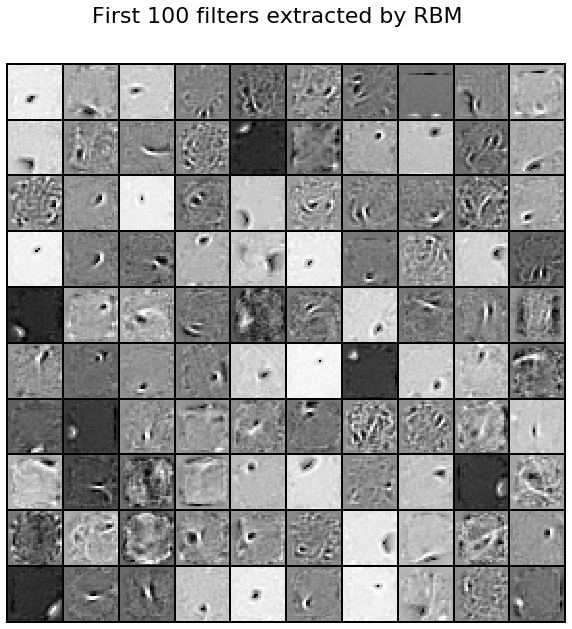

In [5]:
fig = plt.figure(figsize=(10, 10))
plot_matrices(W.T, shape=(28, 28), title='First 100 filters extracted by RBM',
              imshow_params={'cmap': plt.cm.gray});
plt.savefig('rbm_mnist.png', dpi=196);

## load data

In [6]:
X, y = load_mnist(mode='train', path='../data/')
X /= 255.
X_test, y_test = load_mnist(mode='test', path='../data/')
X_test /= 255.
print X.shape, y.shape, X_test.shape, y_test.shape

(60000, 784) (60000,) (10000, 784) (10000,)


## 1) train classifiers on extracted features
### extract features $\mathbb{P}(\mathbf{h}\;|\;\mathbf{v}=\mathbf{x}_i) \;\forall i$

In [7]:
H = rbm.transform(X)
H_test = rbm.transform(X_test)
print H.shape, H_test.shape

INFO:tensorflow:Restoring parameters from ../models/rbm_mnist/model
INFO:tensorflow:Restoring parameters from ../models/rbm_mnist/model


(60000, 1024) (10000, 1024)


### fit Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(multi_class='multinomial', 
                            solver='sag', max_iter=800, tol=1e-5,
                            verbose=10, n_jobs=2, random_state=1337)

logreg.fit(H, y)
print accuracy_score(y_test, logreg.predict(H_test))

max_iter reached after 1995 seconds
0.9801


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 33.2min
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed: 33.2min finished


### fit k-NN

In [9]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score

knn = KNN(n_neighbors=3, p=2., 
          weights='distance', n_jobs=2)

with Stopwatch(verbose=True) as s:
    knn.fit(H, y)
    print accuracy_score(y_test, knn.predict(H_test))

0.9689
Elapsed time: 526.525 sec


## 2) discriminative finetuning
### initialize 2-layer MLP with learned $\mathbf{W}$ and train using Backprop

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# define MLP model
mlp = MLPClassifier(hidden_layer_sizes=(1024,), activation='logistic', solver='lbfgs', 
                    alpha=1e-5, max_iter=200, tol=1e-6, 
                    shuffle=False, verbose=10, warm_start=True) # will output progress to terminal

# initialize weights
mlp.coefs_ = []
mlp.coefs_.append(W)
W2 = RNG(seed=1337).randn(1024, 10) * 0.01
mlp.coefs_.append(W2)

mlp.intercepts_ = []
mlp.intercepts_.append(hb)
mlp.intercepts_.append(np.zeros(10))

mlp.n_layers_ = 3
mlp.out_activation_ = 'softmax'
mlp.n_iter_ = 1

# train and evaluate classifier
with Stopwatch(verbose=True) as s:
    mlp.fit(X, y)
    y_pred = mlp.predict(X_test)
    print accuracy_score(y_test, y_pred)

0.9882
Elapsed time: 960.674 sec


### plot confusion matrix

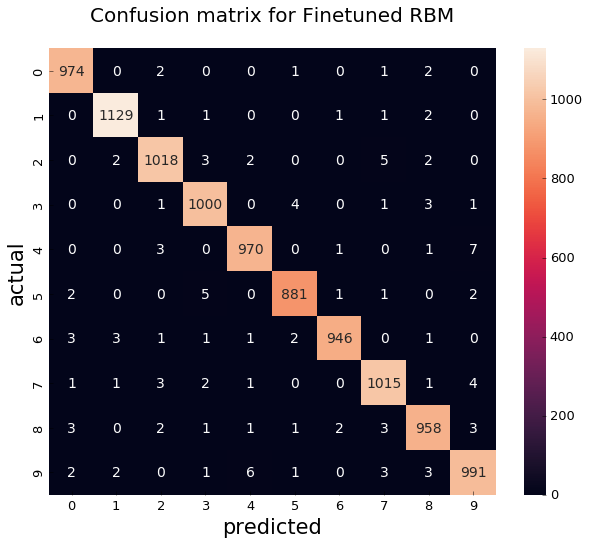

In [11]:
from sklearn.metrics import confusion_matrix

C = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10, 8))
ax = plot_confusion_matrix(C, fmt='d')
plt.title('Confusion matrix for Finetuned RBM\n', fontsize=20)
plt.savefig('rbm_mnist_confusion_matrix.png', dpi=144)

### visualize filters after fine-tuning

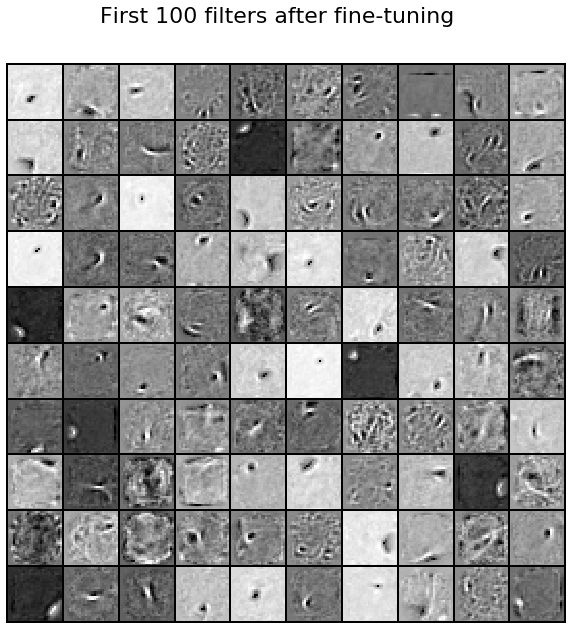

In [12]:
fig = plt.figure(figsize=(10, 10))
plot_matrices(mlp.coefs_[0].T, shape=(28, 28), title='First 100 filters after fine-tuning',
              imshow_params={'cmap': plt.cm.gray});
plt.savefig('rbm_mnist_finetuned.png', dpi=196);

## 3) classification RBMs
A third way to use RBMs for supervised problems is to jointly model distribution of the data along with the labels $\mathbb{P}(\mathbf{x},\;\mathbf{y})$. Such models are called **classification RBMs** (cRBMs). Currently, these are beyond of the scope of this repository.